In [7]:
import time
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from torch.nn import Sequential as Sq
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.autograd as autograd
import argparse


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


class SwissRoll(torch.utils.data.Dataset):
    def __init__(self, n_samples=100000, noise=0.5):
        from sklearn.datasets import make_swiss_roll
        x = make_swiss_roll(n_samples=n_samples, noise=0.5)[0][:,[0, 2]]
        xmin, xmax = x.min(axis=0)[0], x.max(axis=0)[0]
        x = (x - xmin) / (xmax - xmin)
        self.x = torch.FloatTensor(2. * x - 1.)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

In [39]:
class VESDE(nn.Module):
    def __init__(self, min_std=0.001, max_std=10.00):
        super().__init__()
        self.register_buffer('min_std', torch.tensor([min_std]))
        self.register_buffer('max_std', torch.tensor([max_std]))
    
    def sample_t(self, batch_size):
        return torch.rand(batch_size)

    def g(self, t):
        return self.min_std * torch.pow((self.max_std / self.min_std), t)

    def std(self, t):
        return self.g(t)

    def marg_std(self, t):
        coeff = self.min_std / (torch.log(self.max_std / self.min_std))
        integral = coeff * (torch.pow((self.max_std / self.min_std), t) - 1)
        return self.min_std + integral

    @torch.no_grad()
    def sample_euler(self, score_net, num_samples, num_steps=1000):
        device = self.min_std.device
        t = torch.ones(num_samples).to(device).unflatten(0, (-1, *(1 for _ in score_net.shape)))
        x = torch.randn(num_samples, *score_net.shape).to(device)
        time_list = torch.linspace(1., 0., num_steps)
        dt = time_list[0] - time_list[1] # negative value
        for i, time in enumerate(time_list):
            t.fill_(time)
            g = self.g(time)
            dw = dt.sqrt() * torch.randn_like(x)
            dx = (g**2) * score_net(x, t) * dt + g * dw
            x = x + dx
        
        return x

    @torch.no_grad()
    def sample_discrete_diffusion(self, score_net, num_samples, num_steps=1000):
        device = self.min_std.device
        tval = torch.ones(num_samples).to(device).unflatten(0, (-1, *(1 for _ in score_net.shape)))
        z = torch.randn(num_samples, *score_net.shape).to(device)
        time_list = torch.linspace(1., 0., num_steps + 1)
        for i, time in enumerate(time_list[:-1]):

            t = time_list[i]        
            s = time_list[i + 1]

            std_s = self.marg_std(s)
            std_t = self.marg_std(t)
            fstd_t = (std_t.square() - std_s.square()).sqrt()
            
            rstd_s = std_s * fstd_t / std_t
            ralp_0 = rstd_s.square() / std_s.square()
            ralp_t = rstd_s.square() / fstd_t.square()

            tval.fill_(t)
            x_pred = z + std_t.square() * score_net(z, tval)
            rloc_s = ralp_0 * x_pred + ralp_t * z
            z = rloc_s + torch.randn_like(z) * rstd_s
        return x_pred



In [40]:
class Score(nn.Module):
    def __init__(self, x_dim=2, hidden_dim=256):
        super().__init__()
        self.shape = (2, )
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim

        self.net = Sq(nn.Linear(x_dim + 1, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, x_dim))

    def forward(self, x, t):
        return self.net(torch.cat([x, t], -1))

In [41]:
args = argparse.Namespace()

args.min_std = 1e-3
args.max_std = 25.0
args.learning_rate = 1e-4
args.batch_size = 256
args.num_epochs = 100


dataset = SwissRoll()
score_net = Score()
vesde = VESDE(min_std=args.min_std, max_std=args.max_std)
optimizer = optim.Adam(score_net.parameters(), lr=args.learning_rate)
loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
loss_meter = AverageMeter()

In [42]:
for epoch in range(100):
    loss_meter.reset()
    for x in loader:
        
        t = vesde.sample_t(batch_size=x.size()[0])
        t = t.unflatten(0, (-1, *(1 for _ in score_net.shape)))
        optimizer.zero_grad()
        marg_std = vesde.marg_std(t)
        noise = torch.randn_like(x)
        xt = x + marg_std * noise
        score = score_net(xt, t)
        loss = (marg_std * score + noise).square().mean(dim=0).sum()
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item(), x.size()[0])
    print('[epoch %d] | %s: %7.5f |' % (epoch, 'loss', loss_meter.avg))

[epoch 0] | loss: 1.78592 |
[epoch 1] | loss: 1.72827 |
[epoch 2] | loss: 1.70304 |
[epoch 3] | loss: 1.69069 |
[epoch 4] | loss: 1.68074 |
[epoch 5] | loss: 1.67836 |
[epoch 6] | loss: 1.66309 |
[epoch 7] | loss: 1.66206 |
[epoch 8] | loss: 1.64358 |
[epoch 9] | loss: 1.65740 |
[epoch 10] | loss: 1.64296 |
[epoch 11] | loss: 1.64965 |
[epoch 12] | loss: 1.62523 |
[epoch 13] | loss: 1.63021 |
[epoch 14] | loss: 1.61209 |
[epoch 15] | loss: 1.62507 |
[epoch 16] | loss: 1.61046 |
[epoch 17] | loss: 1.60804 |
[epoch 18] | loss: 1.59625 |
[epoch 19] | loss: 1.60101 |
[epoch 20] | loss: 1.59618 |
[epoch 21] | loss: 1.59688 |
[epoch 22] | loss: 1.59111 |
[epoch 23] | loss: 1.59217 |
[epoch 24] | loss: 1.58835 |
[epoch 25] | loss: 1.58706 |
[epoch 26] | loss: 1.58929 |
[epoch 27] | loss: 1.58123 |
[epoch 28] | loss: 1.58759 |
[epoch 29] | loss: 1.58404 |
[epoch 30] | loss: 1.57643 |
[epoch 31] | loss: 1.58448 |
[epoch 32] | loss: 1.57157 |
[epoch 33] | loss: 1.57095 |
[epoch 34] | loss: 1.585

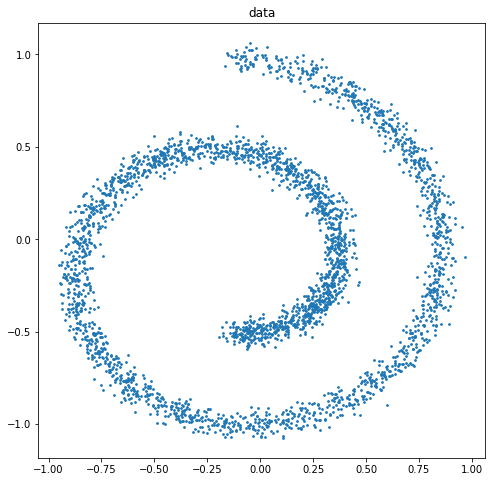

In [44]:
plt.figure(figsize=(8, 8))
plt.title('data')
plt.scatter(dataset.x[:3000, 0], dataset.x[:3000, 1], s=3)
plt.show()

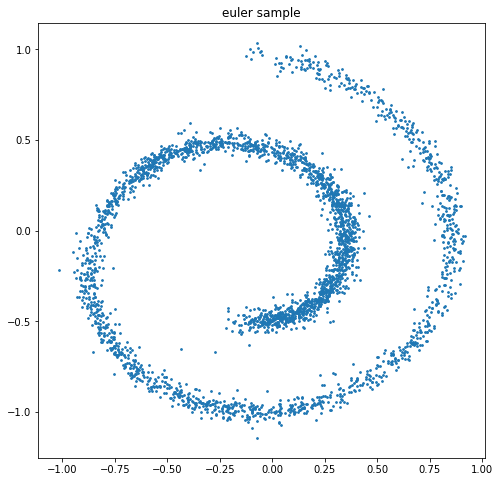

In [47]:
x = vesde.sample_euler(score_net, num_samples=3000, num_steps=1000)
plt.figure(figsize=(8, 8))
plt.title('euler sample')
plt.scatter(x[:, 0], x[:, 1], s=3)
plt.show()

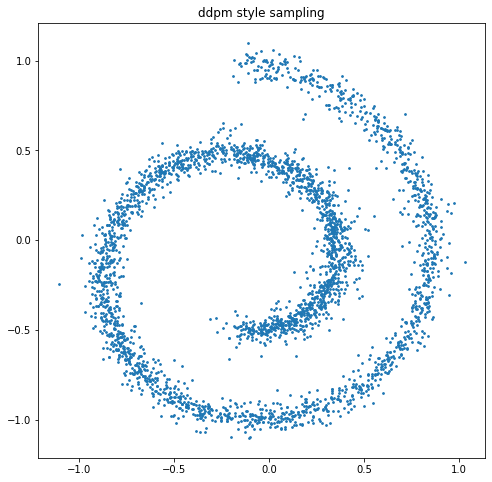

In [48]:
x = vesde.sample_discrete_diffusion(score_net, 3000, 1000)
plt.figure(figsize=(8, 8))
plt.title('ddpm style sampling')
plt.scatter(x[:, 0], x[:, 1], s=3)
plt.show()